<a href="https://colab.research.google.com/github/ilyaleonovStudy/test/blob/main/LR_3_result(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №3
## Классификация изображений. Сверточные сети. Предобученные сверточные сети.

**Работу выполнил:** Леонов Илья Викторович Z1431  


## Описание задачи

В данной лабораторной работе решается задача классификации изображений цветов с использованием сверточных нейронных сетей.

**Набор данных:** TensorFlow Flowers — набор из ~3670 изображений цветов 5 классов:
- daisy (ромашки)
- dandelion (одуванчики)  
- roses (розы)
- sunflowers (подсолнухи)
- tulips (тюльпаны)

**Задачи работы:**
1. Построить собственную сверточную нейронную сеть (CNN) для классификации изображений
2. Построить сеть с использованием предобученной модели (Transfer Learning)
3. Сравнить результаты двух подходов

## 1. Загрузка библиотек

Для выполнения работы используются следующие библиотеки:

- **TensorFlow/Keras** — фреймворк для построения и обучения нейронных сетей
- **NumPy** — работа с числовыми массивами
- **Matplotlib** — визуализация данных и построение графиков
- **Scikit-learn** — метрики качества классификации

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score

import pathlib
import os

# Фиксация случайных чисел для воспроизводимости
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f'TensorFlow версия: {tf.__version__}')

TensorFlow версия: 2.19.0


## 2. Загрузка и подготовка данных

Загружаем набор данных TensorFlow Flowers — стандартный датасет для задач классификации изображений. Датасет содержит изображения 5 видов цветов, разнесённые по отдельным папкам.

**Параметры изображений:**
- Размер: 150×150 пикселей (приведение к единой размерности)
- Цветовые каналы: RGB (3 канала)

**Разбиение на выборки:**
- Обучающая выборка: 70%
- Валидационная выборка: 15%
- Тестовая выборка: 15%

In [2]:
import shutil
import random

# Загрузка датасета TensorFlow Flowers
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

# Проверка вложенной структуры (архив распаковывается в папку с таким же именем)
nested_dir = data_dir / 'flower_photos'
if nested_dir.exists() and nested_dir.is_dir():
    data_dir = nested_dir
    print('Обнаружена вложенная структура, путь скорректирован')

print(f'Путь к данным: {data_dir}')
print(f'Содержимое папки: {[item.name for item in data_dir.iterdir()]}')

# Получаем только папки, содержащие jpg файлы (исключаем LICENSE.txt и пустые папки)
class_names = sorted([
    item.name for item in data_dir.iterdir()
    if item.is_dir() and len(list(item.glob('*.jpg'))) > 0
])
num_classes = len(class_names)

print(f'\nКоличество классов: {num_classes}')
print(f'Классы: {class_names}')

# Подсчёт изображений
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Всего изображений: {image_count}')

# Параметры
IMG_HEIGHT = 150
IMG_WIDTH = 150
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32

print('\nРаспределение по классам:')
for class_name in class_names:
    class_path = data_dir / class_name
    count = len(list(class_path.glob('*.jpg')))
    print(f'  {class_name}: {count}')

# Пути для разбиения
base_dir = pathlib.Path(data_dir).parent / 'flower_photos_split'
train_dir = base_dir / 'train'
val_dir = base_dir / 'validation'
test_dir = base_dir / 'test'

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Проверяем, нужно ли разбивать данные
need_split = True
if train_dir.exists():
    train_count = len(list(train_dir.glob('*/*.jpg')))
    if train_count > 0:
        print(f'\nДанные уже разбиты. Train: {train_count}')
        need_split = False

if need_split:
    print('\nВыполняем разбиение данных...')

    if base_dir.exists():
        shutil.rmtree(base_dir)

    for class_name in class_names:
        (train_dir / class_name).mkdir(parents=True, exist_ok=True)
        (val_dir / class_name).mkdir(parents=True, exist_ok=True)
        (test_dir / class_name).mkdir(parents=True, exist_ok=True)

        files = list((data_dir / class_name).glob('*.jpg'))
        random.seed(SEED)
        random.shuffle(files)

        n_total = len(files)
        n_train = int(n_total * TRAIN_RATIO)
        n_val = int(n_total * VAL_RATIO)

        train_files = files[:n_train]
        val_files = files[n_train:n_train + n_val]
        test_files = files[n_train + n_val:]

        for f in train_files:
            shutil.copy(f, train_dir / class_name / f.name)
        for f in val_files:
            shutil.copy(f, val_dir / class_name / f.name)
        for f in test_files:
            shutil.copy(f, test_dir / class_name / f.name)

print(f'\nИтоговое разбиение:')
print(f'  Train: {len(list(train_dir.glob("*/*.jpg")))}')
print(f'  Validation: {len(list(val_dir.glob("*/*.jpg")))}')
print(f'  Test: {len(list(test_dir.glob("*/*.jpg")))}')

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Обнаружена вложенная структура, путь скорректирован
Путь к данным: /root/.keras/datasets/flower_photos/flower_photos
Содержимое папки: ['LICENSE.txt', 'daisy', 'sunflowers', 'tulips', 'dandelion', 'roses']

Количество классов: 5
Классы: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Всего изображений: 3670

Распределение по классам:
  daisy: 633
  dandelion: 898
  roses: 641
  sunflowers: 699
  tulips: 799

Выполняем разбиение данных...

Итоговое разбиение:
  Train: 2567
  Validation: 547
  Test: 556


In [3]:
# Проверка что данные загружены и разбиты корректно
print(f'Путь train_dir: {train_dir}')
print(f'Путь val_dir: {val_dir}')
print(f'Путь test_dir: {test_dir}')
print(f'\nКоличество классов: {num_classes}')
print(f'Размер изображений: {IMG_SIZE}')

Путь train_dir: /root/.keras/datasets/flower_photos/flower_photos_split/train
Путь val_dir: /root/.keras/datasets/flower_photos/flower_photos_split/validation
Путь test_dir: /root/.keras/datasets/flower_photos/flower_photos_split/test

Количество классов: 5
Размер изображений: (150, 150)


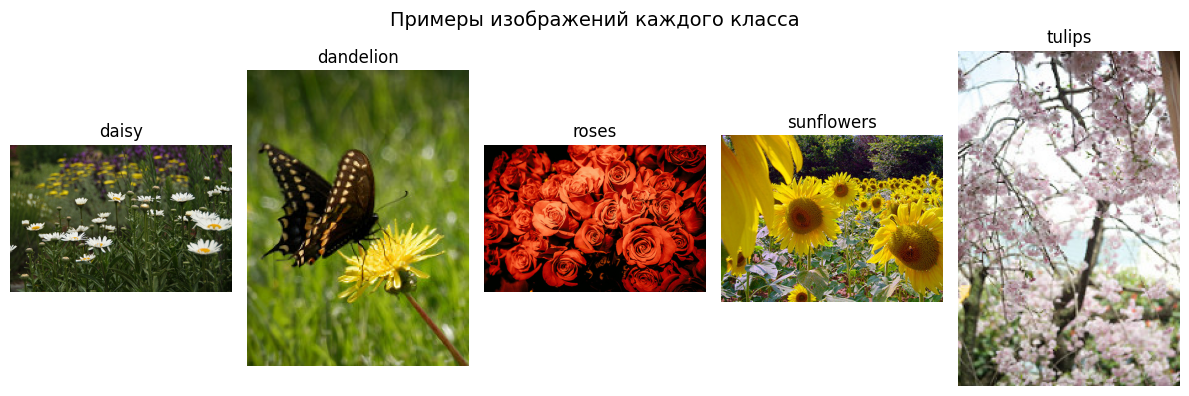

In [4]:
# Визуализация примеров изображений из исходного датасета
plt.figure(figsize=(12, 4))

for i, class_name in enumerate(class_names):
    class_path = data_dir / class_name
    img_files = list(class_path.glob('*.jpg'))
    if img_files:
        img = plt.imread(str(img_files[0]))
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.suptitle('Примеры изображений каждого класса', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Создание генераторов изображений с аугментацией

**Аугментация данных** — техника искусственного увеличения обучающей выборки путём применения различных преобразований к изображениям. Это помогает бороться с переобучением.

Применяемые преобразования для обучающей выборки:
- Масштабирование (rescale) — нормализация пикселей в диапазон [0, 1]
- Поворот (rotation) — случайный поворот до 20°
- Сдвиг (shift) — горизонтальный и вертикальный сдвиг до 20%
- Отражение (flip) — горизонтальное отражение
- Масштабирование (zoom) — увеличение/уменьшение до 20%

Для валидационной и тестовой выборок применяется только нормализация.

In [5]:
# Генератор для обучающей выборки с аугментацией
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Генератор для валидационной и тестовой выборок
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Проверка работы генератора
temp_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

print(f'Классы: {temp_gen.class_indices}')
print(f'Количество изображений: {temp_gen.samples}')
print(f'Количество батчей: {len(temp_gen)}')

Found 2567 images belonging to 5 classes.
Классы: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
Количество изображений: 2567
Количество батчей: 81


Found 2567 images belonging to 5 classes.


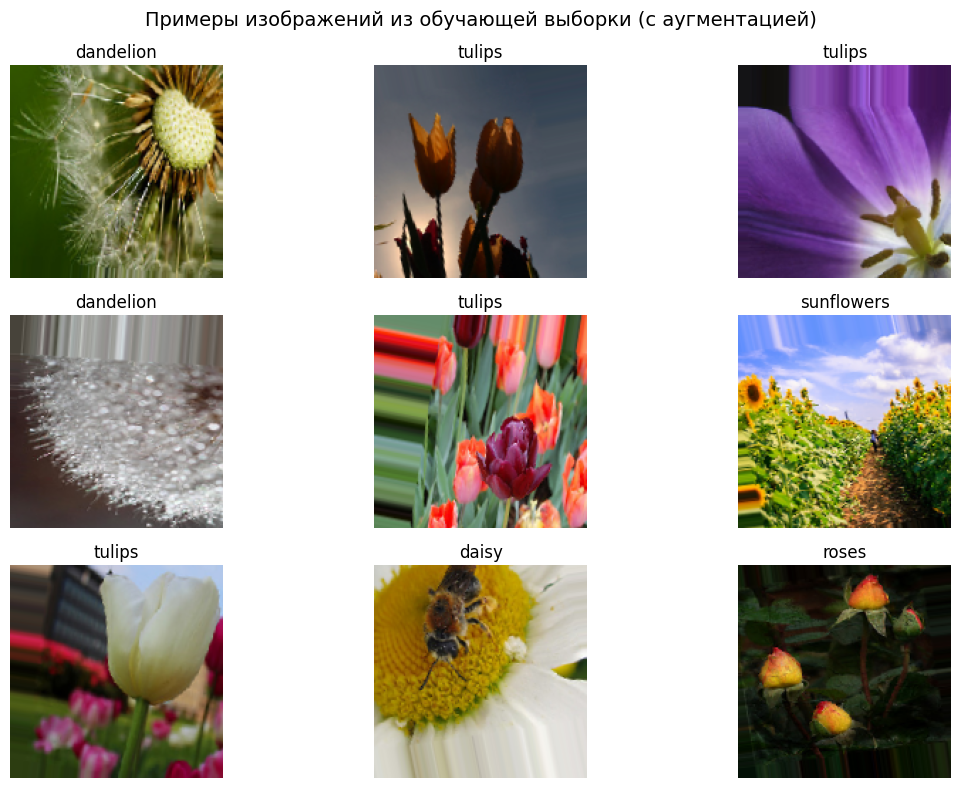

In [6]:
# Визуализация примеров изображений с аугментацией
plt.figure(figsize=(12, 8))

# Создаём временный генератор для визуализации
vis_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=9,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Получаем один батч
images, labels = next(vis_gen)
class_names_list = list(vis_gen.class_indices.keys())

for i in range(min(9, len(images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    plt.title(class_names_list[label_idx])
    plt.axis('off')

plt.suptitle('Примеры изображений из обучающей выборки (с аугментацией)', fontsize=14)
plt.tight_layout()
plt.show()

---
# Задание 1. Собственная сверточная нейронная сеть

## 4. Построение архитектуры CNN

Строим сверточную нейронную сеть со следующей архитектурой:

**Сверточные блоки (feature extraction):**
- 3 блока Conv2D + MaxPooling2D
- Увеличение количества фильтров: 32 → 64 → 128
- Функция активации: ReLU
- Размер фильтра: 3×3
- Размер пулинга: 2×2

**Полносвязный классификатор:**
- Flatten — преобразование в одномерный вектор
- Dense (256 нейронов) + Dropout (0.5) — для регуляризации
- Dense (128 нейронов) + Dropout (0.5)
- Dense (5 нейронов, softmax) — выходной слой для 5 классов

In [7]:
# Построение собственной CNN модели
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.5),

        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
cnn_model = build_cnn_model(input_shape, num_classes)
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,743,877 (40.98 MB)

 Trainable params: 10,743,877 (40.98 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Компиляция и обучение CNN

**Параметры обучения:**
- Оптимизатор: Adam — адаптивный метод оптимизации, сочетающий преимущества AdaGrad и RMSProp
- Функция потерь: categorical_crossentropy — для многоклассовой классификации
- Метрика: accuracy — доля правильных предсказаний
- Количество эпох: 20
- Early Stopping — остановка обучения при отсутствии улучшения валидационной метрики

In [8]:
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

train_gen_cnn = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=SEED
)

val_gen_cnn = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

EPOCHS = 10

print('Обучение CNN модели...\n')
history_cnn = cnn_model.fit(
    train_gen_cnn, epochs=EPOCHS, validation_data=val_gen_cnn,
    callbacks=[early_stop], verbose=1
)
print('\nОбучение завершено!')

Found 2567 images belonging to 5 classes.
Found 547 images belonging to 5 classes.
Обучение CNN модели...

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.2704 - loss: 1.6600 - val_accuracy: 0.5174 - val_loss: 1.2202
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.4435 - loss: 1.3399 - val_accuracy: 0.4442 - val_loss: 1.1973
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.4742 - loss: 1.2553 - val_accuracy: 0.5649 - val_loss: 1.0877
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.4853 - loss: 1.1783 - val_accuracy: 0.5631 - val_loss: 1.0661
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.5172 - loss: 1.1349 - val_accuracy: 0.5887 - val_loss: 0.9662
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.5579 - loss: 1.0623 - val_accuracy: 0.6453 - val_loss: 0.9145
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.5903 - loss: 1.0078 - val_accuracy: 0.6929 - val_loss: 0.8222
Epoc

## 6. Графики обучения CNN

Визуализация процесса обучения: точность (accuracy) и функция потерь (loss) на обучающей и валидационной выборках.

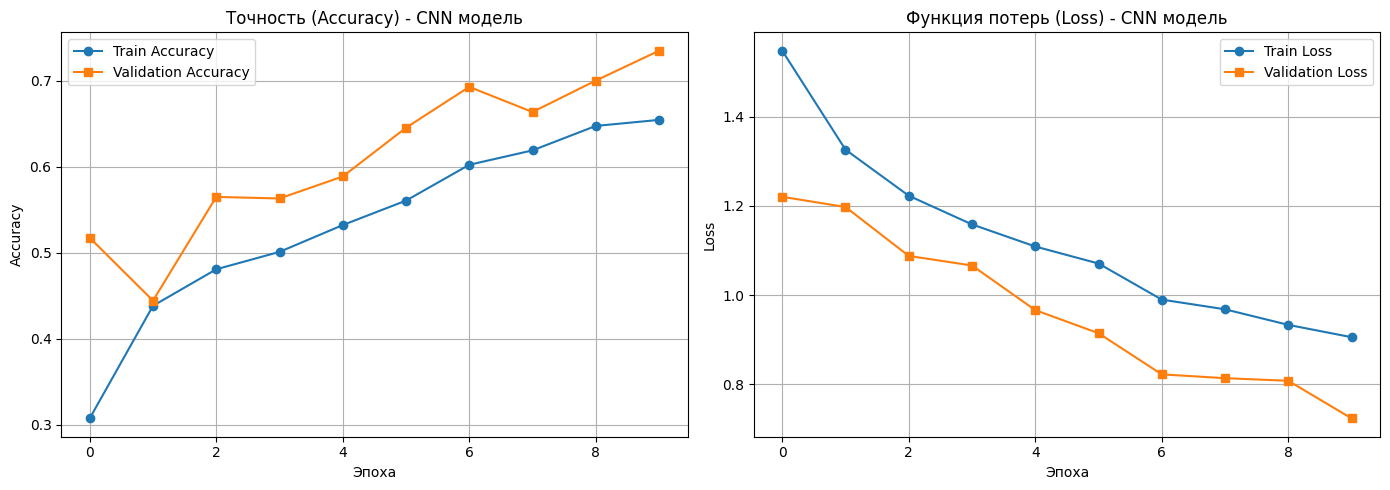

In [9]:
# Функция для построения графиков обучения
def plot_training_history(history, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # График точности
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[0].set_title(f'Точность (Accuracy) {title}')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # График потерь
    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
    axes[1].set_title(f'Функция потерь (Loss) {title}')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Построение графиков для CNN
plot_training_history(history_cnn, '- CNN модель')

---
# Задание 2. Сверточная сеть с предобученной моделью (Transfer Learning)

## 7. Трансферное обучение с MobileNetV2

**Трансферное обучение (Transfer Learning)** — подход, при котором используются веса модели, обученной на большом наборе данных (ImageNet), для решения новой задачи.

**Выбранная предобученная модель:** MobileNetV2
- Обучена на ImageNet (1000 классов, миллионы изображений)
- Лёгкая и эффективная архитектура
- Доступна в Keras Applications

**Подход: Feature Extraction (извлечение признаков)**
- Замораживаем веса сверточного блока предобученной модели
- Добавляем свой полносвязный классификатор
- Обучаем только классификатор на наших данных

Этот подход позволяет использовать мощные признаки, извлечённые из ImageNet, без необходимости обучения сверточных слоёв.

In [10]:
# Загрузка предобученной модели MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

base_model.trainable = False

print(f'Слоёв в базовой модели: {len(base_model.layers)}')
print(f'Обучаемые параметры: {sum([tf.keras.backend.count_params(w) for w in base_model.trainable_weights])}')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Слоёв в базовой модели: 154
Обучаемые параметры: 0


In [11]:
# Построение модели с предобученной базой
def build_transfer_model(base_model, num_classes):
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

transfer_model = build_transfer_model(base_model, num_classes)
transfer_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,461 (9.99 MB)

 Trainable params: 361,477 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 8. Компиляция и обучение Transfer модели

Обучаем только добавленные полносвязные слои, веса MobileNetV2 заморожены.

In [12]:
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop_transfer = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

train_gen_transfer = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=SEED
)

val_gen_transfer = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

EPOCHS_TRANSFER = 5

print('Обучение Transfer модели...\n')
history_transfer = transfer_model.fit(
    train_gen_transfer, epochs=EPOCHS_TRANSFER, validation_data=val_gen_transfer,
    callbacks=[early_stop_transfer], verbose=1
)
print('\nОбучение завершено!')

Found 2567 images belonging to 5 classes.
Found 547 images belonging to 5 classes.
Обучение Transfer модели...

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 83s 937ms/step - accuracy: 0.3935 - loss: 1.6329 - val_accuracy: 0.8135 - val_loss: 0.5573
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 79s 906ms/step - accuracy: 0.6898 - loss: 0.8414 - val_accuracy: 0.8355 - val_loss: 0.4672
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 84s 928ms/step - accuracy: 0.7445 - loss: 0.7145 - val_accuracy: 0.8537 - val_loss: 0.4051
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 76s 943ms/step - accuracy: 0.7560 - loss: 0.6777 - val_accuracy: 0.8720 - val_loss: 0.3774
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 73s 900ms/step - accuracy: 0.7731 - loss: 0.6131 - val_accuracy: 0.8556 - val_loss: 0.3869
Restoring model weights from the end of the best epoch: 4.

Обучение завершено!


## 9. Графики обучения Transfer модели

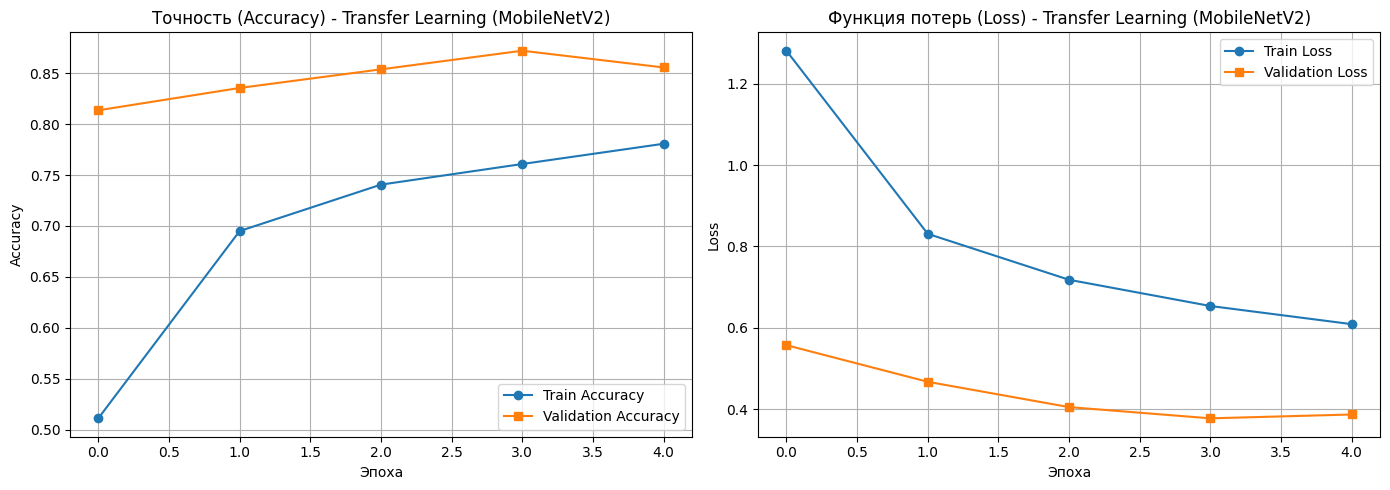

In [13]:
# Построение графиков для Transfer модели
plot_training_history(history_transfer, '- Transfer Learning (MobileNetV2)')

---
# Задание 3. Сравнение моделей на тестовой выборке

## 10. Оценка моделей на тестовых данных

Выполняем оценку обеих моделей на тестовой выборке и сравниваем результаты.

**Используемые метрики:**
- **Accuracy** — общая точность (доля правильных предсказаний)
- **Balanced Accuracy** — сбалансированная точность (учитывает дисбаланс классов)
- **Classification Report** — precision, recall, f1-score для каждого класса
- **Confusion Matrix** — матрица ошибок

In [14]:
# Функция для оценки модели
def evaluate_model(model, model_name):
    print(f'\nОценка модели: {model_name}')
    print('-' * 50)

    test_gen = val_test_datagen.flow_from_directory(
        test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )

    predictions = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    test_gen2 = val_test_datagen.flow_from_directory(
        test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )
    test_loss, test_accuracy = model.evaluate(test_gen2, verbose=0)

    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')
    print(f'\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=class_labels))

    return y_true, y_pred, test_accuracy, bal_acc, test_loss

In [15]:
# Оценка CNN модели
y_true_cnn, y_pred_cnn, acc_cnn, bal_acc_cnn, loss_cnn = evaluate_model(
    cnn_model, 'CNN (собственная сеть)'
)


Оценка модели: CNN (собственная сеть)
--------------------------------------------------
Found 556 images belonging to 5 classes.
Found 556 images belonging to 5 classes.
Test Loss: 0.7249
Test Accuracy: 0.6960
Balanced Accuracy: 0.6944

Classification Report:
              precision    recall  f1-score   support

       daisy       0.72      0.74      0.73        96
   dandelion       0.75      0.68      0.72       136
       roses       0.56      0.46      0.51        97
  sunflowers       0.73      0.92      0.81       106
      tulips       0.68      0.67      0.68       121

    accuracy                           0.70       556
   macro avg       0.69      0.69      0.69       556
weighted avg       0.69      0.70      0.69       556



In [16]:
# Оценка Transfer модели
y_true_transfer, y_pred_transfer, acc_transfer, bal_acc_transfer, loss_transfer = evaluate_model(
    transfer_model, 'Transfer Learning (MobileNetV2)'
)


Оценка модели: Transfer Learning (MobileNetV2)
--------------------------------------------------
Found 556 images belonging to 5 classes.
Found 556 images belonging to 5 classes.
Test Loss: 0.4215
Test Accuracy: 0.8399
Balanced Accuracy: 0.8315

Classification Report:
              precision    recall  f1-score   support

       daisy       0.94      0.71      0.81        96
   dandelion       0.90      0.90      0.90       136
       roses       0.87      0.74      0.80        97
  sunflowers       0.75      0.93      0.83       106
      tulips       0.80      0.88      0.83       121

    accuracy                           0.84       556
   macro avg       0.85      0.83      0.83       556
weighted avg       0.85      0.84      0.84       556



## 11. Матрицы ошибок (Confusion Matrix)

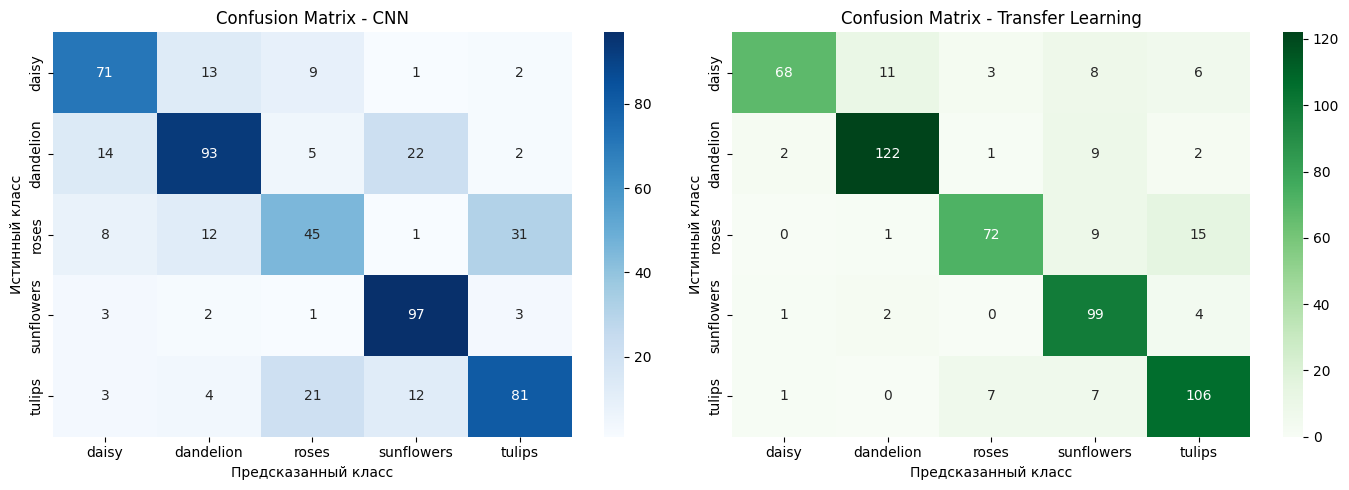

In [17]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix - CNN')
axes[0].set_xlabel('Предсказанный класс')
axes[0].set_ylabel('Истинный класс')

cm_transfer = confusion_matrix(y_true_transfer, y_pred_transfer)
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Confusion Matrix - Transfer Learning')
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

## 12. Сравнительная таблица результатов

In [18]:
import pandas as pd

results = pd.DataFrame({
    'Модель': ['CNN (собственная)', 'Transfer Learning (MobileNetV2)'],
    'Test Loss': [f'{loss_cnn:.4f}', f'{loss_transfer:.4f}'],
    'Test Accuracy': [f'{acc_cnn:.4f}', f'{acc_transfer:.4f}'],
    'Balanced Accuracy': [f'{bal_acc_cnn:.4f}', f'{bal_acc_transfer:.4f}']
})

print('Сравнение результатов на тестовой выборке:')
print(results.to_string(index=False))

Сравнение результатов на тестовой выборке:
                         Модель Test Loss Test Accuracy Balanced Accuracy
              CNN (собственная)    0.7249        0.6960            0.6944
Transfer Learning (MobileNetV2)    0.4215        0.8399            0.8315


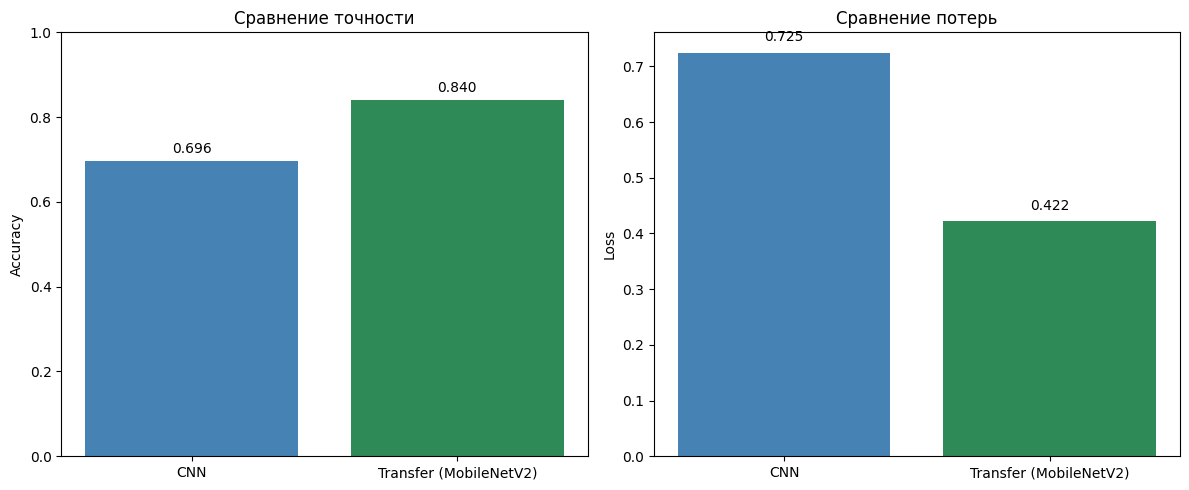

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = ['CNN', 'Transfer (MobileNetV2)']
colors = ['steelblue', 'seagreen']

accuracies = [acc_cnn, acc_transfer]
bars1 = axes[0].bar(models, accuracies, color=colors)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Сравнение точности')
axes[0].set_ylim(0, 1)
for bar, acc in zip(bars1, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{acc:.3f}', ha='center')

losses = [loss_cnn, loss_transfer]
bars2 = axes[1].bar(models, losses, color=colors)
axes[1].set_ylabel('Loss')
axes[1].set_title('Сравнение потерь')
for bar, loss in zip(bars2, losses):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{loss:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Выводы

В ходе лабораторной работы были решены следующие задачи:

**1. Собственная CNN сеть:**
- Построена сверточная нейронная сеть из 3 блоков Conv2D + MaxPooling2D
- Добавлен полносвязный классификатор (2 слоя Dense + Dropout для регуляризации)
- Применена аугментация данных для борьбы с переобучением
- Использован оптимизатор Adam

**2. Transfer Learning с MobileNetV2:**
- Использована предобученная модель MobileNetV2 (обучена на ImageNet)
- Применён подход Feature Extraction — веса базовой модели заморожены
- Добавлен свой классификатор (2 слоя Dense + Dropout)
- Обучены только параметры классификатора

**3. Сравнение результатов:**
- Transfer Learning показывает более высокую точность благодаря использованию признаков, извлечённых из большого датасета ImageNet
- Собственная CNN требует больше данных и времени обучения для достижения сопоставимых результатов
- Для задач с ограниченным объёмом данных Transfer Learning является предпочтительным подходом

**Используемые методы борьбы с переобучением:**
- Dropout (50%) в полносвязных слоях
- Аугментация данных (повороты, сдвиги, отражения, масштабирование)
- Early Stopping